# Image Classification with CNN

In [1]:
from nimrod.utils import set_seed
from nimrod.models.core import lr_finder, train_one_cycle

from hydra.utils import instantiate
from omegaconf import OmegaConf
from rich import print

%load_ext autoreload
%autoreload 2
set_seed()


[16:11:33] INFO - PyTorch version 2.5.1 available.
Seed set to 42
Seed set to 42


## Data

[16:11:34] INFO - Init ImageDataModule for mnist
[16:11:39] INFO - loading dataset mnist with args () from split train
[16:11:46] INFO - loading dataset mnist with args () from split test
[16:11:48] INFO - split train into train/val [0.8, 0.2]
[16:11:48] INFO - train: 48000 val: 12000, test: 10000


_target_: nimrod.image.datasets.ImageDataModule
name: mnist
data_dir: ../data/image
train_val_split:
- 0.8
- 0.2
batch_size: 512
num_workers: 0
pin_memory: true
persistent_workers: false
transforms:
  _target_: torchvision.transforms.Compose
  transforms:
  - _target_: torchvision.transforms.ToTensor
  - _target_: torchvision.transforms.Normalize
    mean:
    - 0.1307
    std:
    - 0.3081

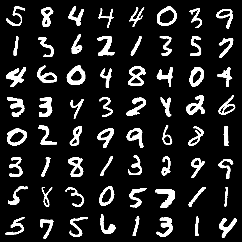

In [2]:
cfg = OmegaConf.load('../config/data/image/mnist.yaml')
cfg.data_dir = "../data/image"
cfg.batch_size = 512
cfg.num_workers = 0
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()
print(OmegaConf.to_yaml(cfg))
xb, yb = next(iter(dm.train_dataloader()))
dm.show_batch(xb[:64])

## Training

In [9]:
# SETUP

N_EPOCHS = 5
do_lr_finder = False

cfg_model = OmegaConf.load('../config/model/image/mlpx.yaml')
cfg_model.nnet.n_in = dm.dim[0] * dm.dim[1]
cfg_model.nnet.n_h = 64
cfg_model.nnet.dropout = 0.1
model = instantiate(cfg_model) #partial

tags = [f"n_h:{cfg_model.nnet.n_h}", f"dropout:{cfg_model.nnet.dropout}",'dev']


# LR Finder
if do_lr_finder:
    suggested_lr = lr_finder(model, dm, plot=True)
    print(f"Suggested learning rate: {suggested_lr}")
else:
    suggested_lr = 1e-4

# ONE-CYCLE TRAINING
train_one_cycle(
    model,
    dm,
    n_epochs=N_EPOCHS,
    max_lr=suggested_lr,
    project_name='MNIST-Classifier',
    tags=tags
    )

[16:28:36] INFO - MLP: init
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[16:28:36] INFO - MLP_X init
[16:28:36] INFO - Classifier: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.


[16:28:37] INFO - Optimizer: <class 'torch.optim.adamw.AdamW'>
[16:28:37] INFO - Scheduler: <class 'torch.optim.lr_scheduler.OneCycleLR'>

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | nnet         | MLP                | 50.9 K | train
1 | loss         | CrossEntropyLoss   | 0      | train
2 | train_acc    | MulticlassAccuracy | 0      | train
3 | val_acc      | MulticlassAccuracy | 0      | train
4 | test_acc     | MulticlassAccuracy | 0      | train
5 | train_loss   | MeanMetric         | 0      | train
6 | val_loss     | MeanMetric         | 0      | train
7 | test_loss    | MeanMetric         | 0      | train
8 | val_acc_best | MaxMetric          | 0      | train
------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │     0.878600001335144     │
│         test/loss         │     0.554068922996521     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆██████████
lr-AdamW,▁▂▂▂▂▄▆▇▇▇█████▇▇▇▇▆▆▅▅▅▅▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
test/acc,▁
test/loss,▁
train/acc_epoch,▁▆███
train/acc_step,▁▁▁▃▃▄▄▅▆▆▇▇▇▇▇▇▇███████▇███████████████
train/loss_epoch,█▄▂▁▁
train/loss_step,██████▇▇▇▆▆▆▅▅▅▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇█
val/acc,▁▇███
val/acc_best,▁▇███
